# Catnip

In [ ]:
# Dependencies and configuration
import importlib
from src.config import settings
from src.setup import setup_dirs

seed_paths, neg_paths = setup_dirs()

## Pre-processing

### Panel extraction

In [ ]:
from modules.coreMPE.src.adenzu_panel.image_processing import panel

_ = panel.extract_panels_for_images_in_folder_recursive(
    input_dir=str(settings.pages_dir),
    output_dir=str(settings.panels_dir),
    split_joint_panels=False,   # maps to --split-joint-panels
    fallback=True              # maps to --fallback
)

### Head crops

In [ ]:
# Extract head crops (YOLOv8_animeface)
from src.headExtraction import anime_extraction_recursive

valid_exts = {".jpg", ".jpeg", ".png"}
panel_paths = sorted(
    [p for p in settings.panels_dir.iterdir() if p.suffix.lower() in valid_exts]
)
num_crops = anime_extraction_recursive()

print(f"Extracted {num_crops} faces")

## Catnip core

### Model building

In [9]:
import src.embeddingModel
importlib.reload(src.embeddingModel)

from src.embeddingModel import compute_embeddings, build_model, load_embeddings

#### New model

In [10]:
# Build fresh model without loading weights (for new embedding computation)
embed_model = build_model(settings.img_size, settings.crops_dir, load_weights=False)
compute_embeddings(embed_model, settings.crops_dir, settings.img_size)

Found 20654 crops under data/crops


Embedding batches: 100%|██████████| 323/323 [00:57<00:00,  5.59it/s]

Successfully embedded 20654 crops
Generated embeddings of shape (20654, 1024)
Saved embeddings to data/embs/embeddings.npy
Saved crop paths to data/embs/crop_paths.json
Saved model weights to src/models/model.weights.h5


(array([[ 0.04540502, -0.04316399,  0.02939501, ..., -0.01981734,
         -0.05998956,  0.00505039],
        [ 0.04204962, -0.020965  ,  0.05578109, ..., -0.02862887,
         -0.04577109,  0.0051598 ],
        [ 0.01971656, -0.03245406,  0.0287459 , ..., -0.04268969,
         -0.08005968, -0.02138615],
        ...,
        [ 0.0557365 , -0.02170262, -0.0507322 , ..., -0.0127388 ,
         -0.0475941 , -0.0074836 ],
        [ 0.0144029 , -0.04293798,  0.02191393, ..., -0.04688694,
         -0.030577  ,  0.00340836],
        [ 0.05482142, -0.02878538, -0.00842562, ...,  0.02382064,
         -0.03079761,  0.03774453]], shape=(20654, 1024), dtype=float32),
 ['data/crops/v12/014_6_face_0.jpg',
  'data/crops/v12/074_0_face_1.jpg',
  'data/crops/v12/084_4_face_0.jpg',
  'data/crops/v12/201_1_face_0.jpg',
  'data/crops/v12/121_5_face_0.jpg',
  'data/crops/v12/114_3_face_1.jpg',
  'data/crops/v12/046_6_face_0.jpg',
  'data/crops/v12/013_6_face_0.jpg',
  'data/crops/v12/083_4_face_0.jpg',
  'd

#### Previous model

In [ ]:
# Build embedding model (loads saved weights if available)
embed_model = build_model(settings.img_size, settings.crops_dir, load_weights=True)
embs, crop_paths = load_embeddings(settings.embed_path, settings.crop_path)

## Outputting

In [11]:
import src.query
import src.output
importlib.reload(src.query) 
importlib.reload(src.output)

from src.query import izutsumi_query, izutsuminess_rank
from src.output import save_similar_results, char_nearest_neighbor

import matplotlib.pyplot as plt

In [12]:
crop, index, score, thre = izutsumi_query(settings.embed_path,
                                        settings.crop_path,
                                        settings.img_size, 
                                        embed_model, 
                                        seed_paths,
                                        neg_paths,
                                        similarity_threshold=-1,
                                        alpha=0.5,
                                        mode='max')

Found 20654 crops above similarity threshold -1


In [8]:
index = izutsuminess_rank(settings.embed_path, settings.crop_path, embed_model, seed_paths, neg_paths)

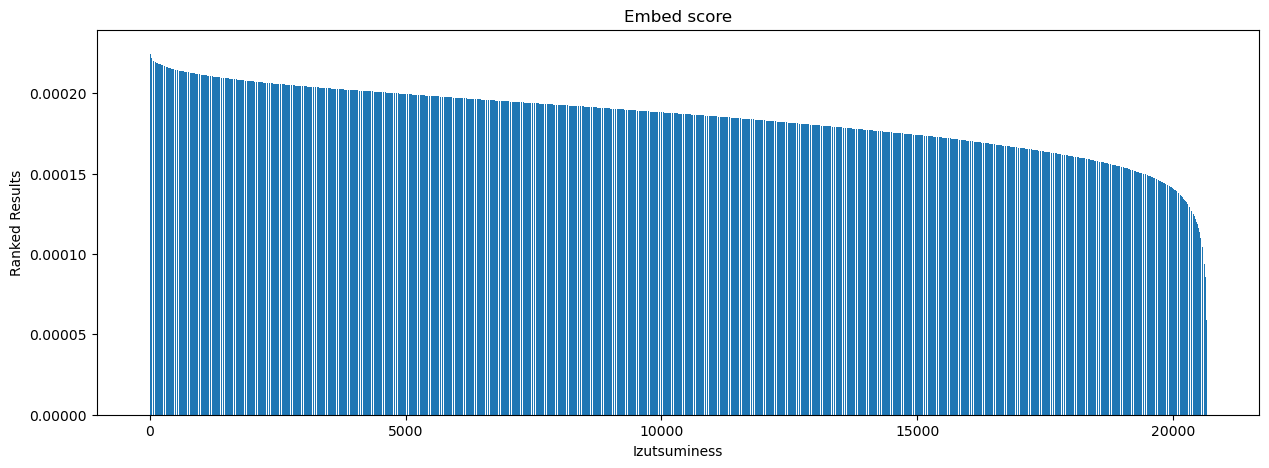

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(index)), score)
plt.xlabel("Izutsuminess")
plt.ylabel("Ranked Results")
plt.title("Embed score")
plt.show()

Showing top 120 results out of 20654 matches


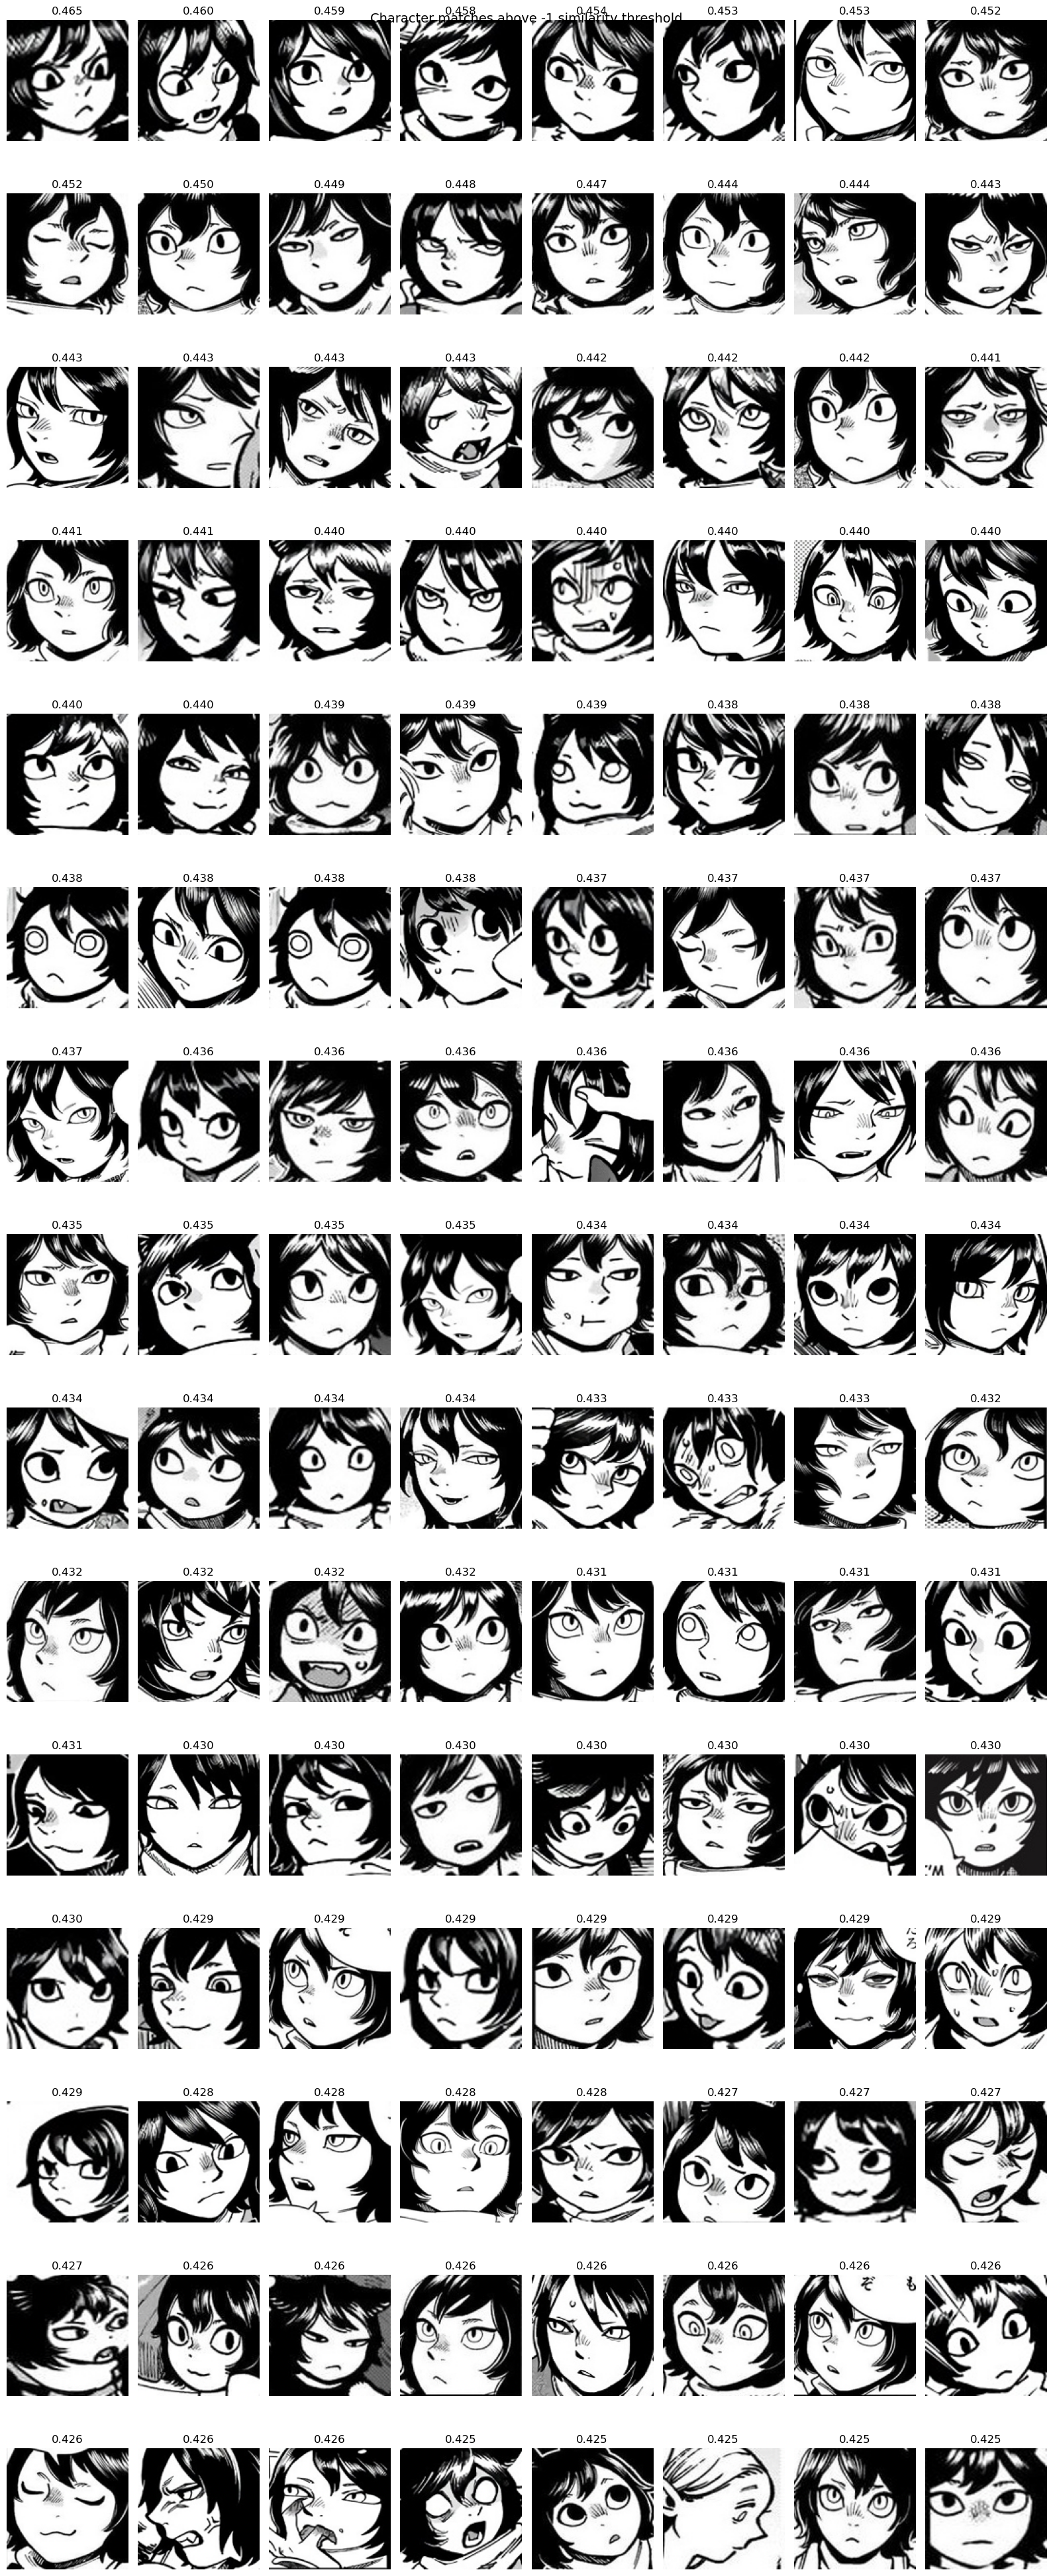

In [13]:
cutoff = 0

results = char_nearest_neighbor(crop, index[cutoff:], score[cutoff:], thre)

In [ ]:
save_similar_results(crop, index, settings.output_dir, score)